# 58AQL Stacked photometry

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import pandas as pd

# Matplotlib style ;)
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')

from astropy.io import fits
from astropy.table import QTable
from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
from photutils.psf import IntegratedGaussianPRF

## Abrindo os ficheiros e lendo a data

In [2]:
dir = "./data 58AQL/"
files = [f for f in os.listdir(dir) if f.endswith('.fits')]
print(files)

['Blue_Stacked_aligned.fits', 'Green_Stacked_aligned.fits', 'Red_Stacked_aligned.fits']


In [3]:
print("Sendo que por agora só vamos querer analisar os fitros B e V temos que: \n")
files = [f for f in files if "Red" not in f]
print(files)

Sendo que por agora só vamos querer analisar os fitros B e V temos que: 

['Blue_Stacked_aligned.fits', 'Green_Stacked_aligned.fits']


Finding the star sources on blue filter

In [4]:
hdu_blue = fits.open(dir + files[0])[0]
hdu_green = fits.open(dir + files[1])[0]

data = hdu_blue.data
#data_g = hdu_green.data

mean, median, std = sigma_clipped_stats(data, sigma=3.0)  

print((mean, median, std))  

(-19.286012730591864, -19.219875493640515, 3.0831660654910866)


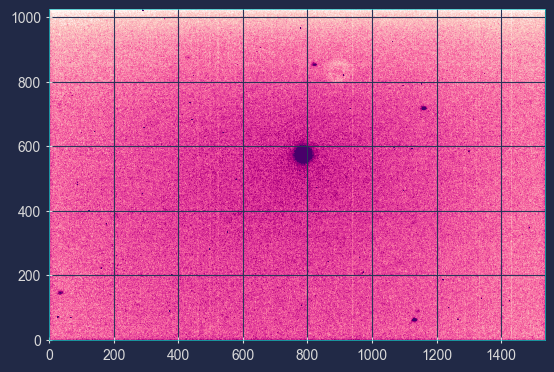

In [5]:
l1 = np.percentile(data[np.isfinite(data)].flatten(), 1.5)
l2 = np.percentile(data[np.isfinite(data)].flatten(), 98.5)
plt.imshow(data, clim = (l1, l2), origin = 'lower')
plt.show()

## Star Finder & source detection

In [6]:
daofind = DAOStarFinder(fwhm=10.0, threshold=10*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)  

 id xcentroid ycentroid sharpness roundness1 ... sky    peak     flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------- -----
  1   1130.61     62.04      0.28       0.06 ... 0.00    14.74    1.56 -0.48
  2   1487.02    347.83      0.22      -0.04 ... 0.00     8.13    1.84 -0.66
  3    788.51    572.74      0.41      -0.02 ... 0.00 15184.10 1224.39 -7.72
  4   1160.41    716.56      0.32       0.06 ... 0.00    14.36    1.22 -0.21


In [7]:
star = sources[sources["id"] == 3]
print("Estrela Standard será:\n",star)

Estrela Standard será:
  id xcentroid ycentroid sharpness roundness1 ... sky    peak     flux   mag 
--- --------- --------- --------- ---------- ... ---- -------- ------- -----
  3    788.51    572.74      0.41      -0.02 ... 0.00 15184.10 1224.39 -7.72


Definig a circle for future reference

In [8]:
from matplotlib.patches import Circle
x,y = (float(star["xcentroid"])),float(star["ycentroid"])
print(x,y)
center = (x,y)
radius = 30
circle = Circle(center, radius,facecolor="None",edgecolor="b")

788.5076324114218 572.7449725749149


C:\Users\João\AppData\Local\Temp\ipykernel_4188\2944884579.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x,y = (float(star["xcentroid"])),float(star["ycentroid"])


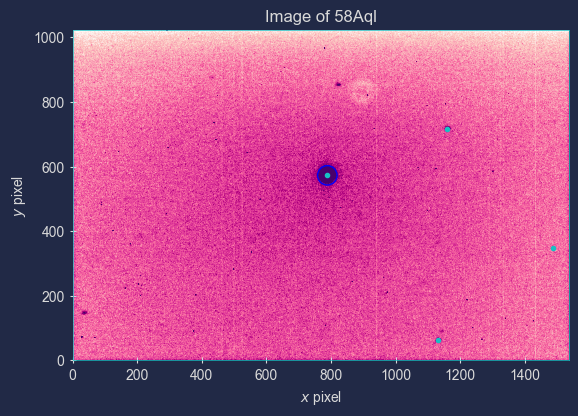

In [9]:
#Plotting fits image
fig, ax = plt.subplots()
l1 = np.percentile(data[np.isfinite(data)].flatten(), 1.5)
l2 = np.percentile(data[np.isfinite(data)].flatten(), 98.5)
plt.imshow(data, clim = (l1, l2), origin = 'lower')

#plotting the found sources
plt.scatter(sources["xcentroid"],sources["ycentroid"], marker = ".")
plt.title('Image of 58Aql')
plt.xlabel(r'$x$ pixel')
plt.ylabel(r'$y$ pixel')
plt.grid(False)

#adding circle
ax.add_patch(circle)
ax.set_aspect('equal')

plt.savefig('58Aql.png', dpi = 600, bbox_inches = 'tight')
plt.show()

## PSF Standard Star
Local Background Subtraction and data read

In [10]:
from photutils.background import LocalBackground, MMMBackground
psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7)# / 2.35)
fit_shape = (5,5)
bkgstat = MMMBackground()
localbkg_estimator = LocalBackground(5, 10, bkgstat)
finder = DAOStarFinder(fwhm=10.0, threshold=10*std) 
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=4,
                        localbkg_estimator=localbkg_estimator)

init_params = QTable()
init_params['x'] = star["xcentroid"]
init_params['y'] = star["ycentroid"]
phot = psfphot(data,init_params=init_params)

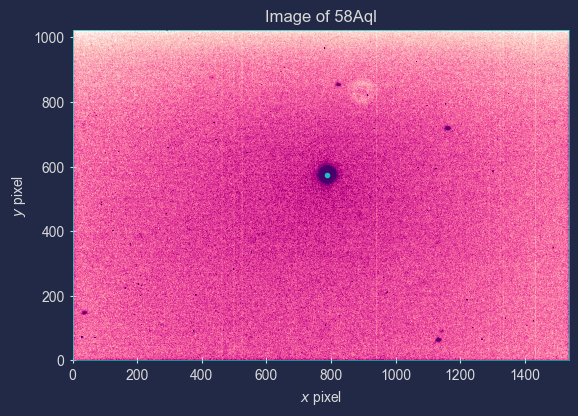

In [11]:
l1 = np.percentile(data[np.isfinite(data)].flatten(), 1.5)
l2 = np.percentile(data[np.isfinite(data)].flatten(), 98.5)
plt.imshow(data, clim = (l1, l2), origin = 'lower')

#plotting the found sources
plt.scatter(phot["x_init"],phot["y_init"], marker = ".")
plt.title('Image of 58Aql')
plt.xlabel(r'$x$ pixel')
plt.ylabel(r'$y$ pixel')
plt.grid(False)

#plt.savefig('58Aql.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [12]:
phot

id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,group_size,qfit,cfit,flags
int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,int32
1,1,1000.2206048527646,788.51,572.74,596967.6312082093,789.8429907218995,572.803794586431,772047.533698574,0.12598125253223075,0.12207428657260318,17714.083666874492,25,1,0.035557293765483194,-0.002168477548075866,0


In [13]:
star = phot.to_pandas()

In [14]:
star

,id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,group_size,qfit,cfit,flags
0,1,1,1000.220605,788.507632,572.744973,596967.631208,789.842991,572.803795,772047.533699,0.125981,0.122074,17714.083667,25,1,0.035557,-0.002168,0


## Calcular Zero Point
Depois de feita a fotometria da estrela Standard, vamos querer descobrir o ZeroPoint para a qual calibrar o resto das nossas estrelas. Para tal a ordem de trabalho será:

1º calcular a magnitude Instrumental: $m_{inst} = −2.5log(flux/t_{exp})$

2º Corrigir para o Airmass: $m_{inst,0} = m_{inst} - k * airmass $. Airmass pode ser consultada nos sites dados e neste caso será: $1.31$ e os valores de k são: $k_V = 0.15$ e $k_B = 0.25$. Os valores dos erros considerados foram os mínimos possíveis dentro da escala dos valores.

3º Calcular Zero Point: $m_{ZP} = m_{std} - m_{inst,0}$ ($m_{std,V} = 5.62$; $B-V = 0.10 \Rightarrow m_{std,B} = 5.72 $)

### Magnitude instrumental e seu erro 
Exposure time foi de 5s para o filtro Blue e 3s para o Green

In [15]:
print(float(star["flux_err"])/float(star["flux_fit"])*100)

2.294429150238112


C:\Users\João\AppData\Local\Temp\ipykernel_4188\2226944625.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(float(star["flux_err"])/float(star["flux_fit"])*100)


In [16]:
mag = -2.5 * np.log10(star["flux_fit"]/5)
mag0 = mag - 1.31 * 0.25
star.insert(len(star.columns), "mag_inst", mag0, False)
#calcular erro da magnitude considerando que o valor do exposure time é "absoluto"
mag_err = np.sqrt((2.5/((star["flux_fit"])*np.log(10)))**2 * (star["flux_err"])**2)
mag0_err = np.sqrt(mag_err**2 + (-1.31)**2 * 0.01**2 + (-0.25)**2 * 0.01**2)
star.insert(len(star.columns), "mag_inst_err", mag0_err, False)

In [17]:
m_ZP = 5.72 - star["mag_inst"]
star.insert(len(star.columns), "Zero_Point", m_ZP, True)
#calcular erro do Zero Point
zp_err = np.sqrt(0.01**2 + star["mag_inst_err"]**2)
star.insert(len(star.columns), "Zero_Point_err", zp_err, True)

In [18]:
star

,id,group_id,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,...,flux_err,npixfit,group_size,qfit,cfit,flags,mag_inst,mag_inst_err,Zero_Point,Zero_Point_err
0,1,1,1000.220605,788.507632,572.744973,596967.631208,789.842991,572.803795,772047.533699,0.125981,...,17714.083667,25,1,0.035557,-0.002168,0,-13.299185,0.028257,19.019185,0.029974


### Zero Point:

In [19]:
print("o valor do Zero Point calculado foi: ZP = (", float(star["Zero_Point"]), "\u00B1" , float(star["Zero_Point_err"]),")")

o valor do Zero Point calculado foi: ZP = ( 19.01918508905203 ± 0.029973992731930316 )


C:\Users\João\AppData\Local\Temp\ipykernel_4188\2163652636.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("o valor do Zero Point calculado foi: ZP = (", float(star["Zero_Point"]), "\u00B1" , float(star["Zero_Point_err"]),")")
